In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("UIDAI_Data_Analysis/Biometric_data.csv")

df.head()

,date,state,district,pincode,bio_age_5_17,bio_age_17_
0,01-03-2025,Maharashtra,Mumbai Suburban,400064,145,138
1,01-03-2025,Maharashtra,Mumbai Suburban,400050,122,203
2,01-03-2025,Maharashtra,Mumbai Suburban,400063,77,104
3,01-03-2025,Maharashtra,Mumbai Suburban,400095,203,355
4,01-03-2025,Maharashtra,Mumbai Suburban,400094,32,33


In [26]:
# Standardize column names
df.columns = df.columns.str.strip().str.lower()
df.columns

Index(['date', 'state', 'district', 'pincode', 'child_biometric',
       'adult_biometric'],
      dtype='object')

In [28]:
df = df.rename(columns={
    'bio_age_5_17': 'child_biometric',
    'bio_age_17_': 'adult_biometric'
})

In [37]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df['date'].head()

0   2025-03-01
1   2025-03-01
2   2025-03-01
3   2025-03-01
4   2025-03-01
Name: date, dtype: datetime64[ns]

In [38]:
# Drop unused columns
df = df.drop(columns=['state', 'district'], errors='ignore')

# Feature engineering
df['total_biometric'] = df['child_biometric'] + df['adult_biometric']

In [39]:
df['total_biometric'] = df['child_biometric'] + df['adult_biometric']

df['child_share'] = df['child_biometric'] / df['total_biometric']
df['adult_share'] = df['adult_biometric'] / df['total_biometric']

df['child_adult_ratio'] = df['child_biometric'] / (df['adult_biometric'] + 1)

df.head()

,date,pincode,child_biometric,adult_biometric,total_biometric,child_share,adult_share,child_adult_ratio
0,2025-03-01,400064,145,138,283,0.51,0.49,1.04
1,2025-03-01,400050,122,203,325,0.38,0.62,0.60
2,2025-03-01,400063,77,104,181,0.43,0.57,0.73
3,2025-03-01,400095,203,355,558,0.36,0.64,0.57
4,2025-03-01,400094,32,33,65,0.49,0.51,0.94


In [40]:
pincode_df = df.groupby('pincode').agg({
    'child_biometric': 'sum',
    'adult_biometric': 'sum',
    'total_biometric': 'sum',
    'date': 'nunique'
}).reset_index()

pincode_df.rename(columns={'date': 'active_days'}, inplace=True)
pincode_df.head()


,pincode,child_biometric,adult_biometric,total_biometric,active_days
0,400024,849,1558,2407,191
1,400029,902,624,1526,182
2,400042,1772,1298,3070,185
3,400043,11750,9593,21343,179
4,400049,540,579,1119,179


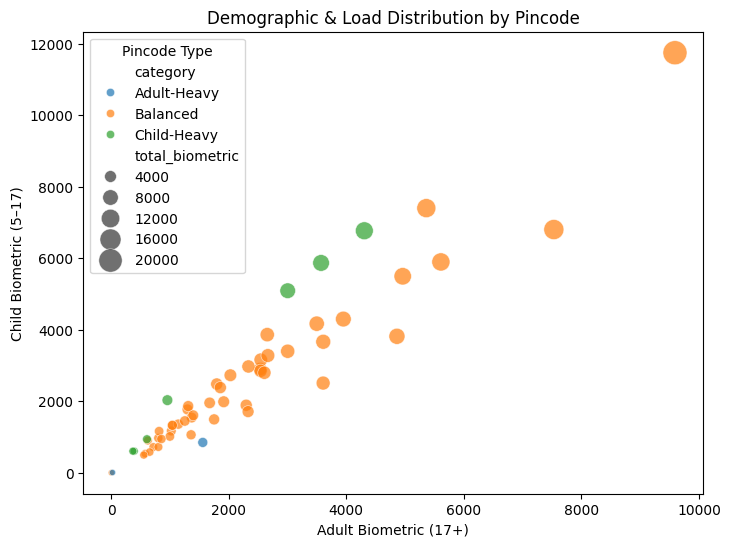

In [53]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='adult_biometric',
    y='child_biometric',
    size='total_biometric',
    hue='category',
    sizes=(20, 300),
    alpha=0.7,
    data=pincode_df
)

plt.title("Demographic & Load Distribution by Pincode")
plt.xlabel("Adult Biometric (17+)")
plt.ylabel("Child Biometric (5–17)")
plt.legend(title="Pincode Type")
plt.show()

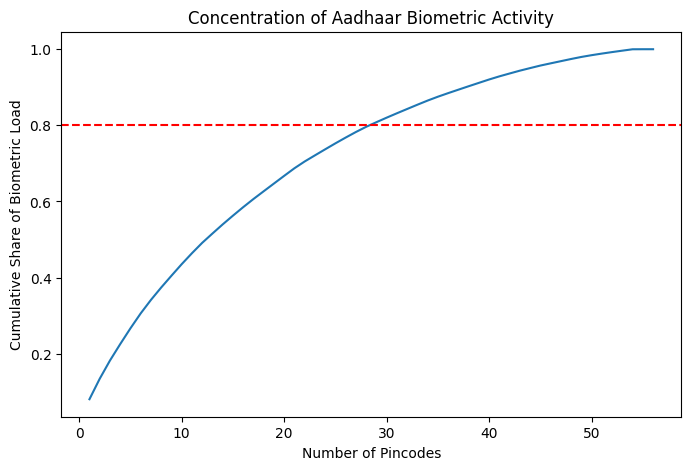

In [54]:
# Sort by total biometric
sorted_df = pincode_df.sort_values('total_biometric', ascending=False)

# Cumulative contribution
sorted_df['cumulative_share'] = (
    sorted_df['total_biometric'].cumsum() /
    sorted_df['total_biometric'].sum()
)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(sorted_df)+1), sorted_df['cumulative_share'])
plt.axhline(0.8, color='red', linestyle='--')
plt.xlabel("Number of Pincodes")
plt.ylabel("Cumulative Share of Biometric Load")
plt.title("Concentration of Aadhaar Biometric Activity")
plt.show()

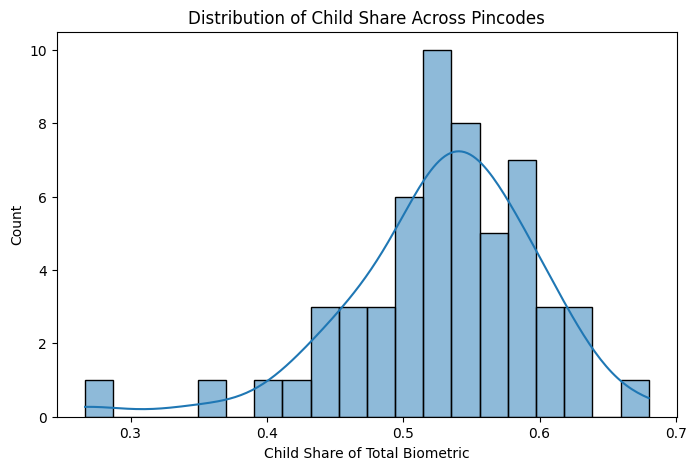

In [55]:
plt.figure(figsize=(8,5))
sns.histplot(
    pincode_df['child_biometric'] / pincode_df['total_biometric'],
    bins=20,
    kde=True
)
plt.xlabel("Child Share of Total Biometric")
plt.title("Distribution of Child Share Across Pincodes")
plt.show()

In [56]:
pincode_df['adult_dominance_score'] = (
    pincode_df['adult_biometric'] / pincode_df['total_biometric']
)

top_migration = pincode_df.sort_values(
    'adult_dominance_score', ascending=False
).head(10)

top_migration[['pincode', 'adult_dominance_score']]

,pincode,adult_dominance_score
48,400096,0.73
0,400024,0.65
36,400083,0.59
44,400092,0.58
16,400061,0.56
47,400095,0.56
5,400050,0.55
8,400053,0.54
46,400094,0.53
50,400098,0.53


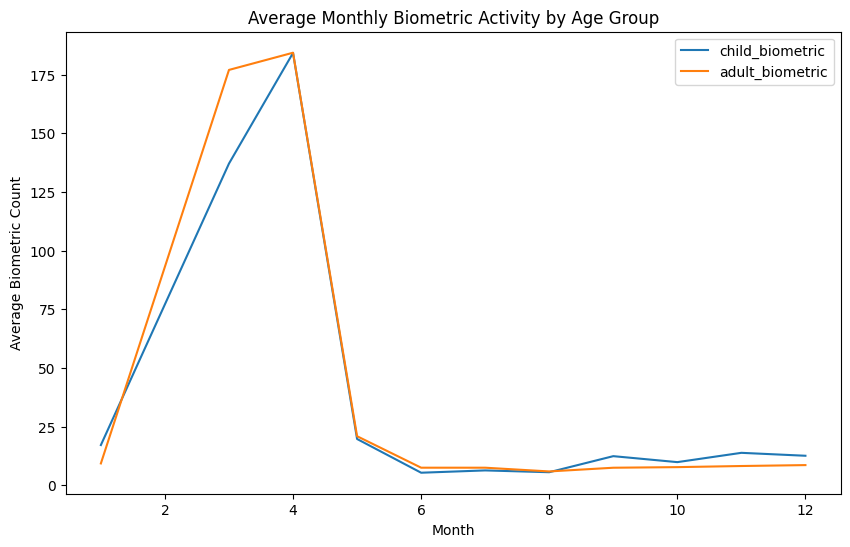

In [57]:
df['month'] = df['date'].dt.month

monthly_avg = df.groupby('month')[['child_biometric','adult_biometric']].mean()

monthly_avg.plot(figsize=(10,6))
plt.title("Average Monthly Biometric Activity by Age Group")
plt.xlabel("Month")
plt.ylabel("Average Biometric Count")
plt.show()

In [58]:
daily = df.groupby(['pincode','date'])['total_biometric'].sum().reset_index()

volatility = daily.groupby('pincode')['total_biometric'].std().reset_index()
volatility.rename(columns={'total_biometric':'volatility'}, inplace=True)

volatile_pincodes = volatility.sort_values('volatility', ascending=False).head(10)
volatile_pincodes

,pincode,volatility
3,400043,192.23
21,400067,156.74
52,400101,146.86
47,400095,109.23
26,400072,107.33
24,400070,100.90
49,400097,97.89
55,400104,95.00
53,400102,79.32
31,400078,78.29


In [60]:
pincode_df['lifecycle_stability_index'] = (
    abs(pincode_df['child_biometric'] - pincode_df['adult_biometric']) /
    pincode_df['total_biometric']
)

stable = pincode_df.sort_values('lifecycle_stability_index').head(10)
unstable = pincode_df.sort_values('lifecycle_stability_index', ascending=False).head(10)

stable[['pincode','lifecycle_stability_index']], unstable[['pincode','lifecycle_stability_index']]

(    pincode  lifecycle_stability_index
 38   400085                       0.00
 12   400057                       0.00
 22   400068                       0.01
 29   400076                       0.01
 18   400064                       0.02
 52   400101                       0.03
 4    400049                       0.03
 33   400080                       0.04
 6    400051                       0.04
 21   400067                       0.05,
     pincode  lifecycle_stability_index
 48   400096                       0.47
 37   400084                       0.36
 0    400024                       0.29
 39   400086                       0.26
 40   400087                       0.24
 31   400078                       0.24
 26   400072                       0.22
 11   400056                       0.21
 35   400082                       0.21
 10   400055                       0.19)

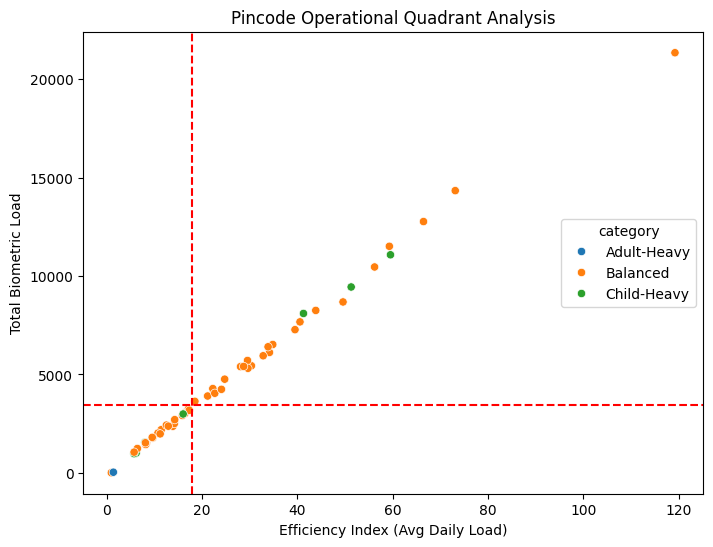

In [66]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='efficiency_index',
    y='total_biometric',
    hue='category',
    data=pincode_df
)

plt.axvline(pincode_df['efficiency_index'].median(), color='red', linestyle='--')
plt.axhline(pincode_df['total_biometric'].median(), color='red', linestyle='--')

plt.xlabel("Efficiency Index (Avg Daily Load)")
plt.ylabel("Total Biometric Load")
plt.title("Pincode Operational Quadrant Analysis")
plt.show()

In [67]:
national_avg = pincode_df['efficiency_index'].mean()

pincode_df['stress_multiplier'] = (
    pincode_df['efficiency_index'] / national_avg
)

high_stress = pincode_df.sort_values(
    'stress_multiplier', ascending=False
).head(10)

high_stress[['pincode', 'stress_multiplier']]

,pincode,stress_multiplier
3,400043,4.65
21,400067,2.85
24,400070,2.59
26,400072,2.32
52,400101,2.31
49,400097,2.19
31,400078,2.00
47,400095,1.93
6,400051,1.71
39,400086,1.61


In [69]:
daily_load = df.groupby(['pincode','date'])['total_biometric'].sum().reset_index()

burst = daily_load.groupby('pincode').agg(
    max_daily=('total_biometric', 'max'),
    avg_daily=('total_biometric', 'mean')
).reset_index()

burst['burst_risk'] = burst['max_daily'] / burst['avg_daily']

burst.sort_values('burst_risk', ascending=False).head(10)

,pincode,max_daily,avg_daily,burst_risk
14,400059,670,22.29,30.06
2,400042,474,16.59,28.56
46,400094,174,6.47,26.91
52,400101,1554,59.32,26.20
55,400104,1060,40.57,26.13
21,400067,1806,73.14,24.69
47,400095,1218,49.60,24.56
43,400091,200,8.16,24.52
53,400102,796,33.88,23.50
34,400081,304,12.95,23.47


In [70]:
pincode_df['migration_imbalance'] = (
    pincode_df['adult_biometric'] /
    (pincode_df['child_biometric'] + 1)
)

pincode_df.sort_values(
    'migration_imbalance', ascending=False
).head(10)

,pincode,child_biometric,adult_biometric,total_biometric,active_days,category,adult_dominance_score,lifecycle_stability_index,load_level,efficiency_index,efficiency_level,stress_multiplier,migration_imbalance
48,400096,8,22,30,21,Adult-Heavy,0.73,0.47,Low Load,1.43,Low Efficiency,0.06,2.44
0,400024,849,1558,2407,191,Adult-Heavy,0.65,0.29,Low Load,12.60,Low Efficiency,0.49,1.83
36,400083,2510,3606,6116,179,Balanced,0.59,0.18,High Load,34.17,High Efficiency,1.33,1.44
44,400092,1712,2329,4041,178,Balanced,0.58,0.15,High Load,22.70,High Efficiency,0.88,1.36
16,400061,1063,1359,2422,193,Balanced,0.56,0.12,Low Load,12.55,Low Efficiency,0.49,1.28
47,400095,3818,4862,8680,175,Balanced,0.56,0.12,High Load,49.60,High Efficiency,1.93,1.27
5,400050,1890,2297,4187,187,Balanced,0.55,0.10,High Load,22.39,High Efficiency,0.87,1.21
8,400053,1494,1751,3245,189,Balanced,0.54,0.08,Low Load,17.17,Low Efficiency,0.67,1.17
46,400094,580,655,1235,191,Balanced,0.53,0.06,Low Load,6.47,Low Efficiency,0.25,1.13
50,400098,497,554,1051,182,Balanced,0.53,0.05,Low Load,5.77,Low Efficiency,0.23,1.11


In [71]:
pincode_df['efficiency_rank'] = pincode_df['efficiency_index'].rank(ascending=False)
pincode_df['volume_rank'] = pincode_df['total_biometric'].rank(ascending=False)

pincode_df['rank_gap'] = abs(
    pincode_df['efficiency_rank'] - pincode_df['volume_rank']
)

pincode_df.sort_values('rank_gap', ascending=False).head(10)

,pincode,child_biometric,adult_biometric,total_biometric,active_days,category,adult_dominance_score,lifecycle_stability_index,load_level,efficiency_index,efficiency_level,stress_multiplier,migration_imbalance,efficiency_rank,volume_rank,rank_gap
16,400061,1063,1359,2422,193,Balanced,0.56,0.12,Low Load,12.55,Low Efficiency,0.49,1.28,40.00,37.00,3.00
23,400069,1322,1040,2362,170,Balanced,0.44,0.12,Low Load,13.89,Low Efficiency,0.54,0.79,37.00,40.00,3.00
14,400059,2483,1796,4279,192,Balanced,0.42,0.16,High Load,22.29,High Efficiency,0.87,0.72,26.00,23.00,3.00
11,400056,940,608,1548,192,Child-Heavy,0.39,0.21,Low Load,8.06,Low Efficiency,0.31,0.65,49.00,46.00,3.00
27,400074,2974,2335,5309,179,Balanced,0.44,0.12,High Load,29.66,High Efficiency,1.16,0.78,18.00,21.00,3.00
20,400066,3161,2545,5706,193,Balanced,0.45,0.11,High Load,29.56,High Efficiency,1.15,0.80,19.00,17.00,2.00
44,400092,1712,2329,4041,178,Balanced,0.58,0.15,High Load,22.70,High Efficiency,0.88,1.36,24.00,26.00,2.00
12,400057,721,717,1438,175,Balanced,0.50,0.00,Low Load,8.22,Low Efficiency,0.32,0.99,47.00,49.00,2.00
15,400060,2904,2535,5439,179,Balanced,0.47,0.07,High Load,30.39,High Efficiency,1.18,0.87,17.00,18.00,1.00
7,400052,971,801,1772,183,Balanced,0.45,0.10,Low Load,9.68,Low Efficiency,0.38,0.82,44.00,45.00,1.00


In [72]:
pincode_df['early_growth_flag'] = (
    pincode_df['child_biometric'] /
    pincode_df['total_biometric']
) > 0.65

pincode_df['early_growth_flag'].value_counts()

early_growth_flag
False    55
True      1
Name: count, dtype: int64

C:\Users\HP\AppData\Local\Temp\ipykernel_7568\2875025378.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  timeline = df.resample('M', on='date')[['child_biometric', 'adult_biometric']].sum()


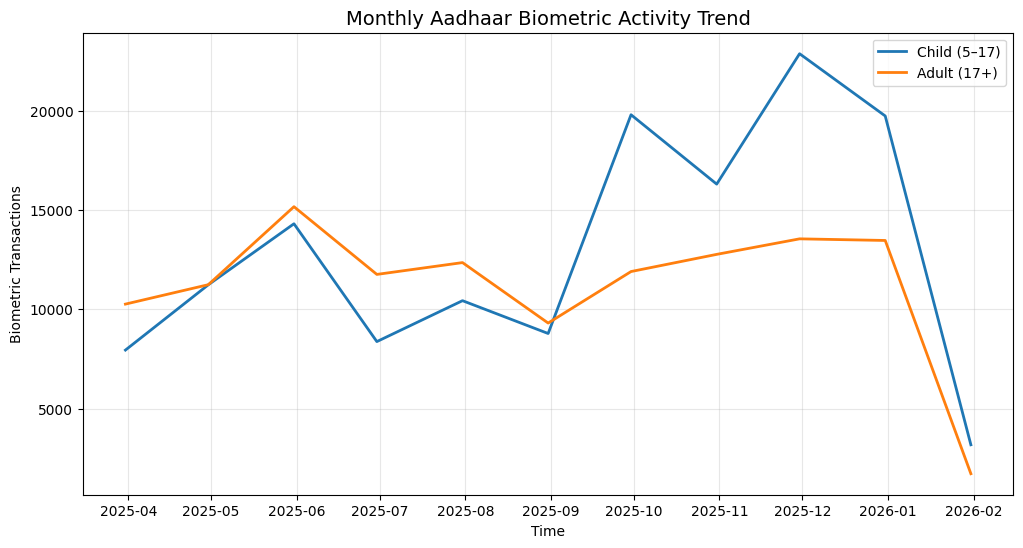

In [73]:
timeline = df.resample('M', on='date')[['child_biometric', 'adult_biometric']].sum()

plt.figure(figsize=(12,6))
plt.plot(timeline.index, timeline['child_biometric'], label='Child (5–17)', linewidth=2)
plt.plot(timeline.index, timeline['adult_biometric'], label='Adult (17+)', linewidth=2)

plt.title("Monthly Aadhaar Biometric Activity Trend", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Biometric Transactions")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


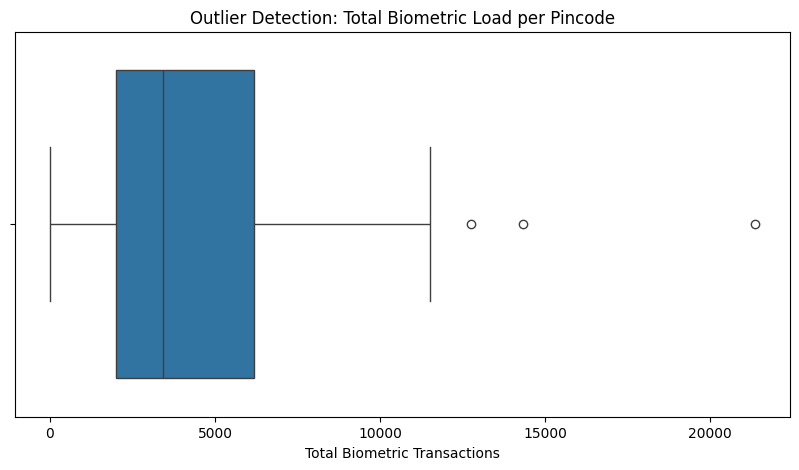

In [74]:
plt.figure(figsize=(10,5))
sns.boxplot(x=pincode_df['total_biometric'])
plt.title("Outlier Detection: Total Biometric Load per Pincode")
plt.xlabel("Total Biometric Transactions")
plt.show()

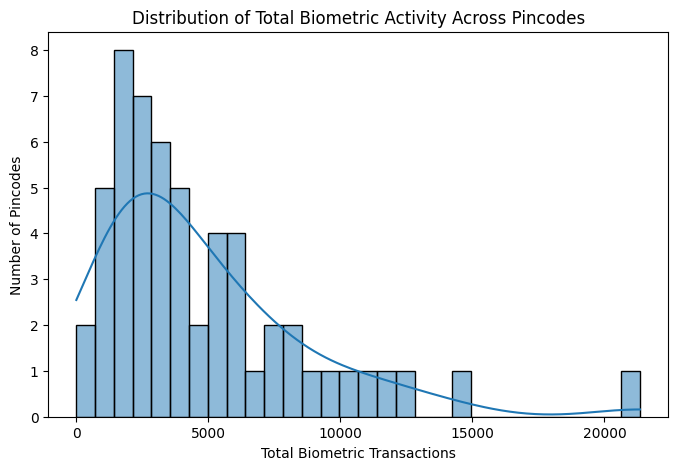

In [75]:
plt.figure(figsize=(8,5))
sns.histplot(pincode_df['total_biometric'], bins=30, kde=True)
plt.title("Distribution of Total Biometric Activity Across Pincodes")
plt.xlabel("Total Biometric Transactions")
plt.ylabel("Number of Pincodes")
plt.show()

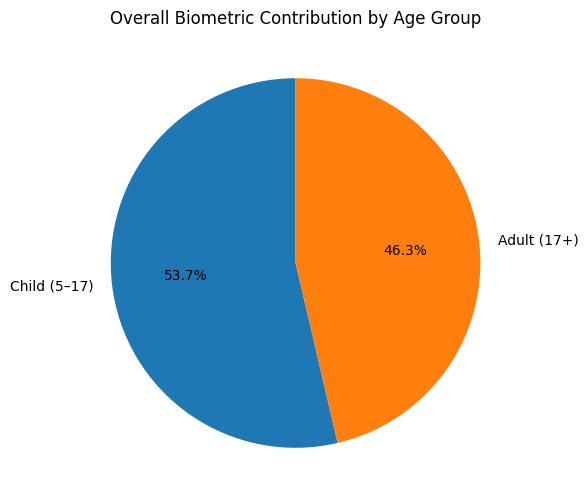

In [76]:
total_child = pincode_df['child_biometric'].sum()
total_adult = pincode_df['adult_biometric'].sum()

plt.figure(figsize=(6,6))
plt.pie(
    [total_child, total_adult],
    labels=['Child (5–17)', 'Adult (17+)'],
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Overall Biometric Contribution by Age Group")
plt.show()

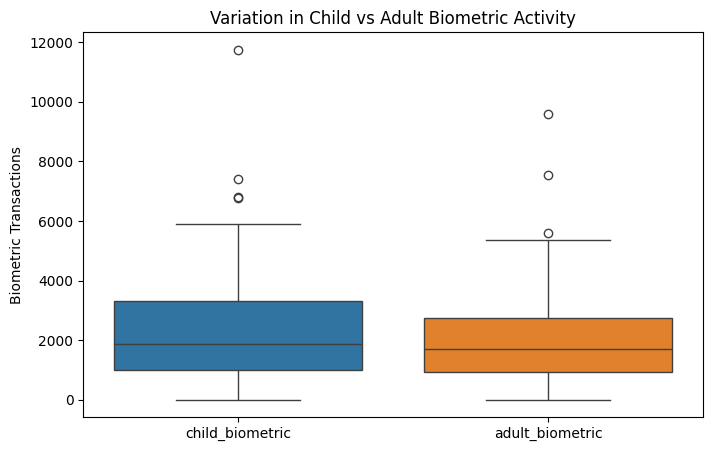

In [77]:
plt.figure(figsize=(8,5))
sns.boxplot(data=pincode_df[['child_biometric', 'adult_biometric']])
plt.title("Variation in Child vs Adult Biometric Activity")
plt.ylabel("Biometric Transactions")
plt.show()

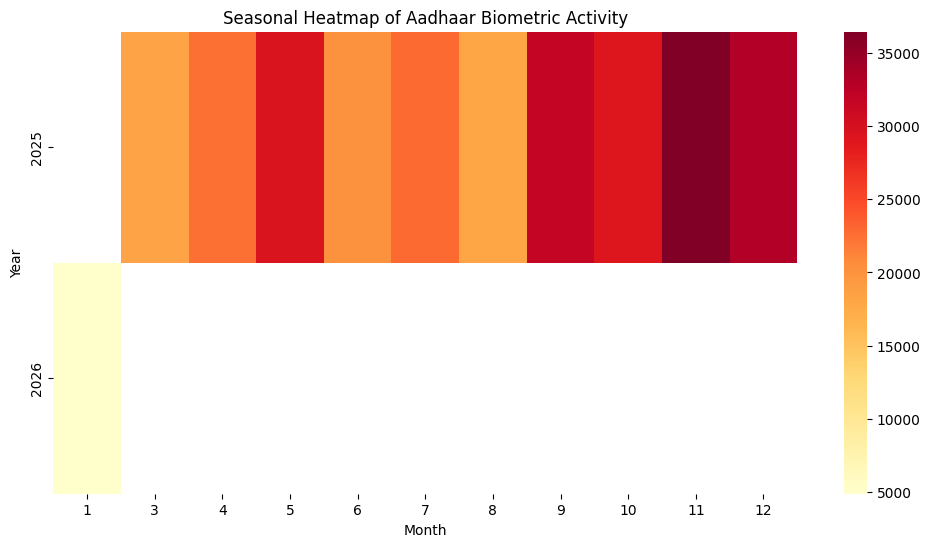

In [78]:
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

heatmap_data = df.groupby(['year','month'])['total_biometric'].sum().unstack()

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap='YlOrRd')
plt.title("Seasonal Heatmap of Aadhaar Biometric Activity")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

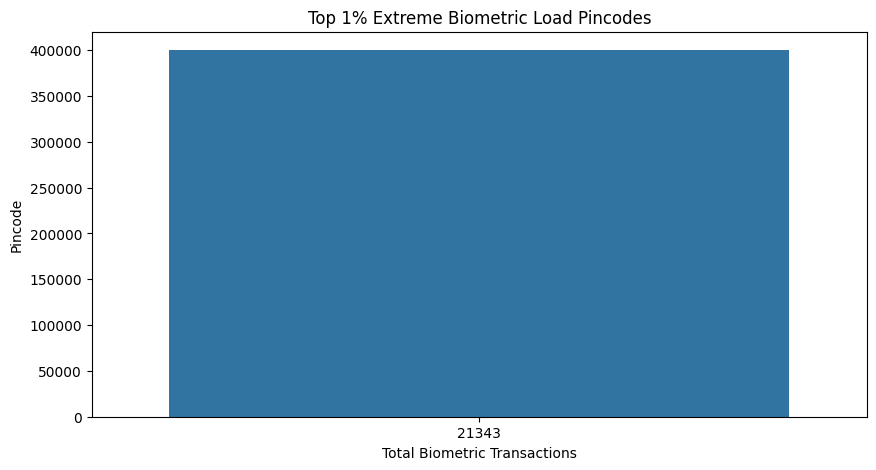

In [79]:
threshold = pincode_df['total_biometric'].quantile(0.99)
extreme = pincode_df[pincode_df['total_biometric'] >= threshold]

plt.figure(figsize=(10,5))
sns.barplot(x='total_biometric', y='pincode', data=extreme)
plt.title("Top 1% Extreme Biometric Load Pincodes")
plt.xlabel("Total Biometric Transactions")
plt.ylabel("Pincode")
plt.show()

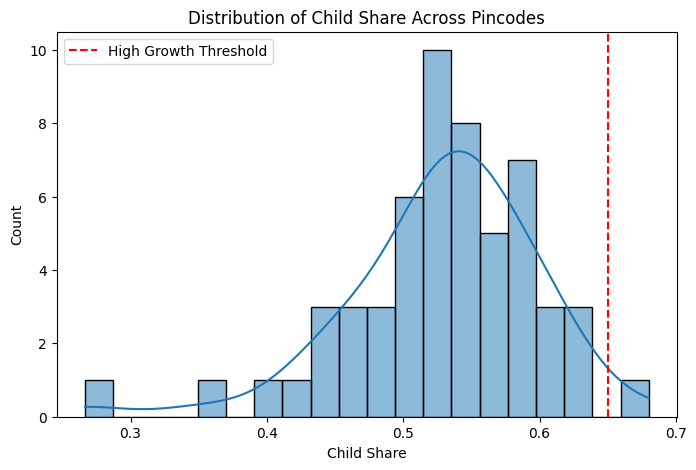

In [80]:
pincode_df['child_share'] = (
    pincode_df['child_biometric'] / pincode_df['total_biometric']
)

plt.figure(figsize=(8,5))
sns.histplot(pincode_df['child_share'], bins=20, kde=True)
plt.axvline(0.65, color='red', linestyle='--', label='High Growth Threshold')
plt.legend()
plt.title("Distribution of Child Share Across Pincodes")
plt.xlabel("Child Share")
plt.show()